In [1]:
%matplotlib inline

In [2]:
#Required to fetch envrio variables 
import os

import pandas as pd
import geopandas
import sqlite3
from shapely import wkt
import folium
from mapboxgl.viz import *
from mapboxgl.utils import *


# Must be a public token, starting with `pk`
token = os.environ['Mapbox_Public_Token']

In [3]:
conn = sqlite3.connect('cap_data.db')
#query = "select * from cap_alerts"
#query = "select cap_alerts.refID, cap_alerts.identifier, cap_alerts.sender, cap_alerts.sent, cap_alerts.status, cap_alerts.msgType, cap_alerts.rev_refid, cap_info.infoID, cap_info.expires,cap_info.event,cap_info.category,cap_info.certainty,cap_info.severity,cap_info.headline,cap_info.description,cap_info.instruction,cap_poly.polygon from cap_alerts, cap_info, cap_area, cap_poly where cap_alerts.refID = cap_info.refID and cap_info.refid = cap_area.refID and cap_info.infoid = cap_area.infoID and cap_area.areaDesc = cap_poly.areaDesc and datetime(cap_info.expires) >= datetime('now') ORDER BY cap_info.expires ASC"
query = """select cap_alerts.refID,
	cap_alerts.identifier, 
	cap_alerts.sender, 
	cap_alerts.sent, 
	cap_alerts.status,
	cap_alerts.msgType,
	cap_info.infoID,    
	cap_info.expires,
	cap_info.event,
	cap_info.category,
	cap_info.responseType,
	cap_info.certainty,
	cap_info.severity,
	cap_info.urgency,
	cap_info.headline,
	cap_info.description,
	cap_info.instruction,
	cap_poly.polygon,
	cap_alerts.rev_refID
	from cap_alerts, cap_info, cap_area, cap_poly 
	where cap_alerts.refID = cap_info.refID 
	and cap_info.refid = cap_area.refID 
	and cap_info.infoid = cap_area.infoID 
	and cap_area.areaDesc = cap_poly.areaDesc
	and datetime(cap_info.expires) >= datetime('now')
	and rev_refID is NULL
	ORDER BY cap_alerts.sent DESC
"""
df = pd.read_sql_query(query,conn)


In [4]:
df.head()

,refID,identifier,sender,sent,status,msgType,infoID,expires,event,category,responseType,certainty,severity,urgency,headline,description,instruction,polygon,rev_refID
0,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0511648...",urn:oid:2.49.0.1.124.0511648341.2020,cap-pac@canada.ca,2020-07-17T21:00:49-00:00,Actual,Alert,0,2020-07-17T23:59:49-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 5:00 p.m. EDT, Environment Canada meteoro...",\nLightning kills and injures Canadians every ...,"POLYGON ((-73.0007 47.7998, -73.0004 48.3331, ...",None
1,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0863640...",urn:oid:2.49.0.1.124.0863640683.2020,cap-pac@canada.ca,2020-07-17T20:43:49-00:00,Actual,Update,0,2020-07-18T12:42:49-00:00,weather,Met,Monitor,Possible,Minor,Future,special weather statement in effect,\nHeat on tap for the weekend\n\nA heat wave w...,None,"POLYGON ((-77.7479 46.1941, -77.7484 46.2127, ...",None
2,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0863640...",urn:oid:2.49.0.1.124.0863640683.2020,cap-pac@canada.ca,2020-07-17T20:43:49-00:00,Actual,Update,0,2020-07-18T12:42:49-00:00,weather,Met,Monitor,Possible,Minor,Future,special weather statement in effect,\nHeat on tap for the weekend\n\nA heat wave w...,None,"POLYGON ((-77.5534 46.1101, -77.5207 46.1336, ...",None
3,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0863640...",urn:oid:2.49.0.1.124.0863640683.2020,cap-pac@canada.ca,2020-07-17T20:43:49-00:00,Actual,Update,0,2020-07-18T12:42:49-00:00,weather,Met,Monitor,Possible,Minor,Future,special weather statement in effect,\nHeat on tap for the weekend\n\nA heat wave w...,None,"POLYGON ((-76.2307 45.5134, -76.231 45.5154, -...",None
4,"cap-pac@canada.ca,urn:oid:2.49.0.1.124.0863640...",urn:oid:2.49.0.1.124.0863640683.2020,cap-pac@canada.ca,2020-07-17T20:43:49-00:00,Actual,Update,0,2020-07-18T12:42:49-00:00,weather,Met,Monitor,Possible,Minor,Future,special weather statement in effect,\nHeat on tap for the weekend\n\nA heat wave w...,None,"POLYGON ((-76.2836 46.0998, -76.3196 46.341, -...",None


In [5]:
# Convert WKT data in polygon column to shapely format for gdf
df['polygon'] = df['polygon'].apply(wkt.loads)
#df.head()

In [6]:
# Create GeoDataFrame
gdf = geopandas.GeoDataFrame(df, geometry='polygon')

In [7]:
# Dissolve data based on ID and info_count 
gdf = gdf.dissolve(by=['identifier', 'infoID'], aggfunc='first')

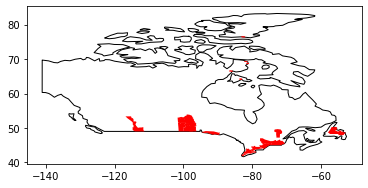

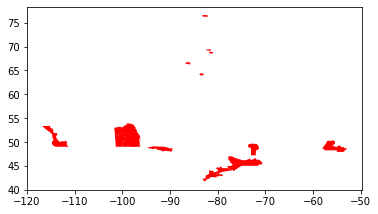

In [8]:
import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
gdf.plot(color='red')
plt.show()

In [9]:
gdf.count()

polygon         22
refID           22
sender          22
sent            22
status          22
msgType         22
expires         22
event           22
category        22
responseType    22
certainty       22
severity        22
urgency         22
headline        22
description     22
instruction     15
rev_refID        0
dtype: int64

In [10]:
gdf.drop('sender', axis=1)
gdf.drop('status', axis=1)
gdf.drop('msgType', axis=1)
gdf.drop('event', axis=1)
gdf.drop('category', axis=1)
gdf.drop('rev_refID', axis=1)

# Write out to GeoJson file.
gdf.to_file("cdn_alerts.geojson", driver='GeoJSON')
gdf.head()

,,polygon,refID,sender,sent,status,msgType,expires,event,category,responseType,certainty,severity,urgency,headline,description,instruction,rev_refID
identifier,infoID,,,,,,,,,,,,,,,,,
5BA7F0C5-3379-8D7B-F3BE-06059CC3C224,0,"POLYGON ((-109.75040 50.45310, -109.75040 50.4...",SaskAlert@SKProvincialEmergencyCommunicationsC...,SaskAlert@SKProvincialEmergencyCommunicationsC...,2020-07-16T14:32:56-06:00,Actual,Alert,2020-07-23T15:00:00-06:00,Drinking Water,Health,Monitor,Observed,Moderate,Immediate,Precautionary Drinking Water Advisory Alert is...,A Precautionary Drinking Water Advisory has be...,Boil water for at least 1 minute prior to use....,None
FB202BA5-D386-5DBE-09D6-F9654AD531FC,0,"POLYGON ((-105.40430 51.71820, -105.42160 51.7...",SaskAlert@SKProvincialEmergencyCommunicationsC...,SaskAlert@SKProvincialEmergencyCommunicationsC...,2020-07-16T15:13:31-06:00,Actual,Alert,2020-07-23T17:00:00-06:00,Drinking Water,Health,Monitor,Observed,Moderate,Immediate,Precautionary Drinking Water Advisory Alert is...,A Precautionary Drinking Water Advisory has be...,Boil water for at least 1 minute prior to use....,None
urn:oid:2.49.0.1.124.0372400513.2020,0,"POLYGON ((-83.28030 76.63810, -82.45460 76.626...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0372400...",cap-pac@canada.ca,2020-07-17T19:15:52-00:00,Actual,Update,2020-07-18T11:14:52-00:00,wind,Met,Monitor,Likely,Moderate,Future,wind warning in effect,\nStrong easterly wind gusts near 90 km/h are ...,None,None
urn:oid:2.49.0.1.124.0511648341.2020,0,"POLYGON ((-73.00070 47.79980, -73.00040 48.333...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0511648...",cap-pac@canada.ca,2020-07-17T21:00:49-00:00,Actual,Alert,2020-07-17T23:59:49-00:00,thunderstorm,Met,Monitor,Likely,Moderate,Immediate,severe thunderstorm warning in effect,"\nAt 5:00 p.m. EDT, Environment Canada meteoro...",\nLightning kills and injures Canadians every ...,None
urn:oid:2.49.0.1.124.0863640683.2020,0,"POLYGON ((-74.69730 45.03860, -74.63560 45.053...","cap-pac@canada.ca,urn:oid:2.49.0.1.124.0863640...",cap-pac@canada.ca,2020-07-17T20:43:49-00:00,Actual,Update,2020-07-18T12:42:49-00:00,weather,Met,Monitor,Possible,Minor,Future,special weather statement in effect,\nHeat on tap for the weekend\n\nA heat wave w...,None,None


In [11]:
#gdf.to_file("ShapeFiles/cdn_alerts.shp", driver='ESRI Shapefile')

In [12]:
#import fiona
#fiona.supported_drivers

In [13]:
match_color_stops = [['AllClear', 'rgb(46,204,113)'],
                     ['Monitor', 'rgb(231,76,60)']]
# https://raw.githubusercontent.com/camwatson/SpatialDataSets/master/Canada_Alerts_English.geojson"
viz = ChoroplethViz("./cdn_alerts.geojson", 
                    access_token=token,
                    color_property='responseType', 
                    color_stops=match_color_stops, 
                    color_function_type='match', 
                    color_default='rgba(52,73,94,0.5)', 
                    opacity=0.8, 
                    center=(-96, 55), 
                    zoom=3, 
                    below_layer='waterway-label')
viz.show()



In [14]:
m = folium.Map(
    location=[55, -130],
    zoom_start=2  # Limited levels of zoom for free Mapbox tiles.
)

folium.GeoJson(
    gdf.to_json(),
    name='geojson',
).add_to(m)


In [15]:
m